In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sys
sys.path.append('../')
import config

In [3]:
import fastsimbac_helper
import identical_run_sim

# Visualize the effect of population isolation on IBS distributions

In [ ]:
# scan of time in fastsimbac simulations

# the full set of split time parameters scanned
params = [0.01, 0.03, 0.1, 0.3, 1, 3]

genome_length = 1e6
theta = 0.01
recomb_len = 10000
pop_size = 50
num_pairs = 1000
between_data = np.zeros((num_pairs, len(params)))
within_data = np.zeros((num_pairs, len(params)))

for j, t in enumerate(params):
    dat_path = './fastsimbac_res/l={}/t={}.txt'.format(recomb_len, t)
    fsb_helper = fastsimbac_helper.fastsimbacHelper(dat_path, None)
    within_pairs, between_pairs = fastsimbac_helper.sample_within_between_pairs(pop_size, num_pairs)
    within_runs = fsb_helper.get_max_runs(within_pairs)
    within_runs = np.array(within_runs) * genome_length
    within_data[:, j] = within_runs

    between_runs = fsb_helper.get_max_runs(between_pairs)
    between_runs = np.array(between_runs) * genome_length
    between_data[:, j] = between_runs

In [5]:
between_L99s = np.percentile(between_data, 99, axis=0)
within_L99 = np.percentile(within_data[:, 0], 99)

<Figure size 400x300 with 0 Axes>

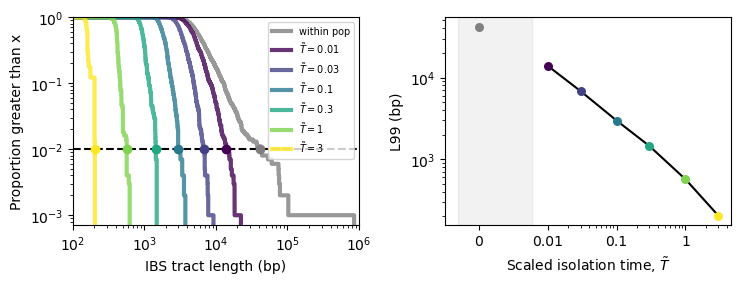

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import LogNorm
from matplotlib.ticker import FixedLocator

# Simulation parameters
t_values = params
# Separate t=0 for special color treatment
t_nonzero = [t for t in t_values if t > 0]

# Log normalization for nonzero t values
log_norm = LogNorm(vmin=min(t_nonzero), vmax=max(t_nonzero))
colormap = cm.viridis  # Choose a colormap

# Create the plot
plt.figure(figsize=(4, 3))
fig, axes = plt.subplots(1, 2, figsize=(8.5, 2.7))
plt.subplots_adjust(wspace=0.3)

ax = axes[0]
ax.scatter(within_L99, 0.01, color='tab:grey')
sns.ecdfplot(within_data[:, 0], label='within pop', complementary=True,
                linewidth=3, alpha=0.8, color='tab:grey', ax=ax)

for i, t in enumerate(t_values):
    color = colormap(log_norm(t))  # Map the log-scaled t value to a color
    between_runs = between_data[:, i]
    #              linewidth=3, alpha=0.5)
    sns.ecdfplot(between_runs, label=r'$\tilde{T}='+ r'{}$'.format(params[i]), complementary=True,
                    linewidth=3, alpha=0.8, color=color, ax=ax)
    
    ax.scatter(between_L99s[i], 0.01, color=color)

ax.axhline(0.01, color='black', linestyle='--', zorder=0)

ax.set_xlim(1e2, 1e6)
ax.set_xscale('log')
ax.set_yscale('log')

# Customize the plot
ax.legend(loc='upper right', fontsize=7)
ax.set_xlabel('IBS tract length (bp)')
ax.set_ylabel('Proportion greater than x')

ax = axes[1]
s = 30
for i in range(len(params)):
    t = params[i]
    color = colormap(log_norm(t))
    ax.scatter(params[i], between_L99s[i], color=color, s=s)
ax.loglog(params, between_L99s, '-', color='k', zorder=0)

within_label_pos = 1e-3
ax.scatter(within_label_pos, within_L99, color='grey', s=s)
ax.set_xticks([within_label_pos, 1e-2, 1e-1, 1e0], labels=['0', '0.01', '0.1', '1'])
min_minor_tick = 1e-2
# ax = plt.gca()
ax.xaxis.set_minor_locator(FixedLocator([k * 10**n for n in range(-2, 1) for k in range(2, 10) if k * 10**n >= min_minor_tick]))

ax.axvspan(within_label_pos/2, min_minor_tick * 0.6, color='gray', alpha=0.1)

ax.set_xlabel(r'Scaled isolation time, $\tilde{T}$')
ax.set_ylabel('L99 (bp)')

plt.savefig(config.supp_fig_path / 'L99_years_fastsimbac.pdf', bbox_inches='tight')

# Comparison of approximate simulation and ground truth

In [7]:
# First get the fsb results 
# the full set of parameters scanned
params = [0.01,0.03,0.05,0.07,0.1,0.3,0.5,0.7,1,3]

genome_length = 1e6
theta = 0.01
recomb_len = 10000
pop_size = 50
num_pairs = 1000
between_data = np.zeros((num_pairs, len(params)))
within_data = np.zeros((num_pairs, len(params)))

for j, t in enumerate(params):
    dat_path = './fastsimbac_res/l={}/t={}.txt'.format(recomb_len, t)
    fsb_helper = fastsimbac_helper.fastsimbacHelper(dat_path, None)
    within_pairs, between_pairs = fastsimbac_helper.sample_within_between_pairs(pop_size, num_pairs)
    within_runs = fsb_helper.get_max_runs(within_pairs)
    within_runs = np.array(within_runs) * genome_length
    within_data[:, j] = within_runs

    between_runs = fsb_helper.get_max_runs(between_pairs)
    between_runs = np.array(between_runs) * genome_length
    between_data[:, j] = between_runs

In [8]:
genome_length = 1e6
theta = 0.01
recomb_len = 10000
t = 0.1
dat_path = './fastsimbac_res/l={}/t={}.txt'.format(recomb_len, t)
fsb_helper = fastsimbac_helper.fastsimbacHelper(dat_path, None)

In [9]:
within_pairs, between_pairs = fastsimbac_helper.sample_within_between_pairs(50, 1000)

In [10]:
within_runs = fsb_helper.get_max_runs(within_pairs)
within_runs = np.array(within_runs) * genome_length

between_runs = fsb_helper.get_max_runs(between_pairs)
between_runs = np.array(between_runs) * genome_length

Simulate mutation accumulation for a range of split times on the within-population genome pairs.

In [11]:
ts = np.logspace(-2, 0.5, 10)
# res_max_runs = []
res_max_runs = np.zeros((len(within_pairs), len(ts)))

for i, pair in enumerate(within_pairs):
    # mag1 = row['genome1']
    # mag2 = row['genome2']
    full_runs = fsb_helper.get_pair_identical_runs(pair)
    full_runs = (full_runs * genome_length).astype(int)
    for j, t in enumerate(ts):
        mut_rate = 2 * t * theta
        sim_runs = identical_run_sim.simulate_mut_accumulation_one_genome(full_runs, mut_rate)
        sim_max = np.max(sim_runs)
        res_max_runs[i, j] = sim_max

In [12]:
L99s = np.percentile(res_max_runs, 99, axis=0)

Plotting the simulated L99-isolation time curves and compare them to the ground truth.

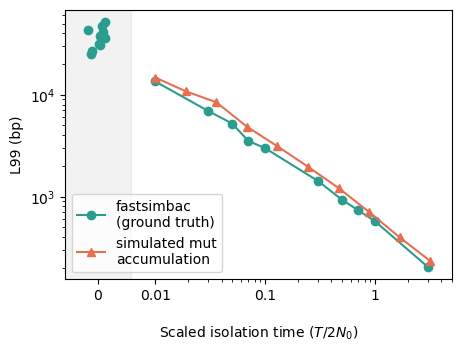

In [13]:
import config
from matplotlib.ticker import LogLocator, NullFormatter, FixedLocator

ground_truth_color = '#2a9d8f'  # Teal/green
approx_sim_color = '#e76f51'    # Coral
analytic_curve_color = '#264653'  # Slate gray

plt.figure(figsize=(5, 3.5))

fsb_L99s = np.percentile(between_data, 99, axis=0)
# skipping the first one, which is no split
plt.plot(params, fsb_L99s, marker='o', color=ground_truth_color, label='fastsimbac\n(ground truth)')
plt.plot(ts, L99s, marker='^', color=approx_sim_color, label='simulated mut\naccumulation')

theta = 0.01
xs = np.logspace(-2, np.log10(2), 100)
muT = xs * theta
ys = 1 / muT
plt.xscale('log')
plt.yscale('log')


# plot the zeros
within_L99s = np.percentile(within_data, 99, axis=0)
within_label_pos = 3e-3
xs = within_label_pos * np.random.uniform(0.8, 1.2, len(params))
plt.plot(xs, within_L99s, 'o', color=ground_truth_color)
plt.xticks([within_label_pos, 1e-2, 1e-1, 1e0], labels=['0\n', '0.01', '0.1', '1'])

min_minor_tick = 1e-2
ax = plt.gca()
ax.xaxis.set_minor_locator(FixedLocator(
    [k * 10**n for n in range(-2, 1) for k in range(2, 10) if k * 10**n >= min_minor_tick]))

ax.axvspan(within_label_pos/2, min_minor_tick * 0.6, color='gray', alpha=0.1)
plt.xlim(within_label_pos / 2, 5)

plt.xlabel('Scaled isolation time ($T / 2N_0$)')
plt.ylabel('L99 (bp)')
plt.legend(loc='lower left')

plt.savefig(config.supp_fig_path / 'L99_years_comparison.pdf', bbox_inches='tight')